# Imports 

In [1]:
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from scipy.io import loadmat

%matplotlib inline

# Load data

### Faces

In [2]:
faces_path = './facesYale.mat'
faces = loadmat(faces_path)

person_train = faces['personTrain']
faces_train = faces['facesTrain']
features_train = faces['featuresTrain']


person_test = faces['personTest']
faces_test = faces['facesTest']
features_test = faces['featuresTest']

### Spambase

In [3]:
spambase_path = './spambase.mat'
spambase = loadmat(spambase_path)

spam_features_train = spambase['featuresTrain']
spam_features_test = spambase['featuresTest']
spam_classes_train = spambase['classesTrain']
spam_classes_test = spambase['classesTest']

### Hypercubes

In [4]:
hypercubes_path = './multiDimHypercubes.mat'
hypercubes = loadmat(hypercubes_path)

hyper_features_train_set = hypercubes['featuresTrain']
hyper_features_test_set = hypercubes['featuresTest']
hyper_classes_train_set = hypercubes['classesTrain']
hyper_classes_test_set = hypercubes['classesTest']

generator = list(zip(
    hyper_features_train_set[0],
    hyper_features_test_set[0],
    hyper_classes_train_set[0],
    hyper_classes_test_set[0],
))

# Define helper methods

In [5]:
def plot(things):
    plt.scatter(range(1, len(things) + 1), things)
    plt.plot()
    
def euclid_dist(train_examples, test_example):
    return np.sqrt(np.sum((train_examples - test_example)**2, axis=1))

# Define nearest_neighbor model

In [6]:
def nearest_neighbor(train_features, test_features, train_classes):
    if test_features.ndim == 1:
        test_features = np.expand_dims(test_features, axis=0)
    results = []
    for test_example in test_features:
        distances = euclid_dist(train_features, test_example)
        results.append(train_classes[np.argmin(distances)])
    return np.array(results)

In [7]:
persons_pred = nearest_neighbor(features_train, features_test, person_train)
acc_score = accuracy_score(person_test, persons_pred)
error = 1 - acc_score
print(f"Error on test faces set: {error}")

Error on test faces set: 0.06666666666666665


In [8]:
accuracies = []
for alpha in range(1, 21):
    features_train_temp = features_train.copy()
    features_test_temp = features_test.copy()
    
    features_train_temp[:,-1] *= alpha
    features_test_temp[:,-1] *= alpha
    
    persons_pred = nearest_neighbor(features_train_temp, features_test_temp, person_train)
    acc_score = accuracy_score(person_test, persons_pred)
    accuracies.append(acc_score)
errors = 1 - np.array(accuracies)

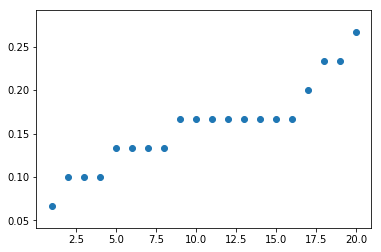

In [9]:
plot(errors)

# Conclusion:

As we can see on the graph, increasing the `alpha` parameters increases the total error on test test.
Increasing `alpha` increases the length of distance component along that axis. It diminishes the impact of other features in the calculated distance.

In [10]:
spam_pred = nearest_neighbor(spam_features_train, spam_features_test, spam_classes_train)
acc = accuracy_score(spam_classes_test, spam_pred)
print(f"Accuracy score on test spam set: {acc}")

Accuracy score on test spam set: 0.8209497841399682


In [11]:
spam_features_all = np.concatenate([spam_features_train, spam_features_test])
spam_classes_all = np.concatenate([spam_classes_train, spam_classes_test])

###### Prepare boolean mask for k-fold cross validation

In [12]:
spam_len = len(spam_features_all)
folds = np.linspace(0, spam_len, 6)
mask = np.zeros((spam_len), dtype=np.bool)
mask[:int(round(folds[1]))] = True

###### Run 5-fold CV

In [13]:
for trial  in range(10):   
    for k in range(5):
        np.random.shuffle(mask)
        test_feature = spam_features_all[mask]
        train_feature = spam_features_all[~mask]
        test_classes = spam_classes_all[mask]
        train_classes = spam_classes_all[~mask]
        spam_pred = nearest_neighbor(train_feature, test_feature, train_classes)
        acc = accuracy_score(test_classes, spam_pred)
        print(f"Accuracy score on fold {k} in trial {trial}: {acc}")   

Accuracy score on fold 0 in trial 0: 0.9141304347826087
Accuracy score on fold 1 in trial 0: 0.8978260869565218
Accuracy score on fold 2 in trial 0: 0.9163043478260869
Accuracy score on fold 3 in trial 0: 0.9271739130434783
Accuracy score on fold 4 in trial 0: 0.8967391304347826
Accuracy score on fold 0 in trial 1: 0.9195652173913044
Accuracy score on fold 1 in trial 1: 0.9065217391304348
Accuracy score on fold 2 in trial 1: 0.9141304347826087
Accuracy score on fold 3 in trial 1: 0.9021739130434783
Accuracy score on fold 4 in trial 1: 0.9304347826086956
Accuracy score on fold 0 in trial 2: 0.9195652173913044
Accuracy score on fold 1 in trial 2: 0.9152173913043479
Accuracy score on fold 2 in trial 2: 0.8967391304347826
Accuracy score on fold 3 in trial 2: 0.9141304347826087
Accuracy score on fold 4 in trial 2: 0.9206521739130434
Accuracy score on fold 0 in trial 3: 0.9021739130434783
Accuracy score on fold 1 in trial 3: 0.9065217391304348
Accuracy score on fold 2 in trial 3: 0.908695652

# Conclusion:

The accuracy scores have comparable value, all of them oscillate around ~90%. The error here is much smaller here, because in the original training/test set split the training set was ~20x smaller than the test set (what is really strange).

# Hypercubes

In [14]:
errors = []
for dim, dataset in enumerate(generator, 1):
    hyper_features_train,    hyper_features_test, \
    hyper_classes_train,    hyper_classes_test = dataset
    predictions = nearest_neighbor(
        hyper_features_train,
        hyper_features_test,
        hyper_classes_train
    )
    error = 1 - accuracy_score(hyper_classes_test, predictions)
    errors.append(error)

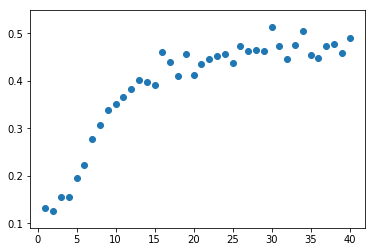

In [15]:
plot(errors)

# Conclusion:

We can see that the overall error increases with increasing the dimension. This is known in machine learning as `curse of dimensionality`. It decreases the predictive power of models since we need more and more data to fill the space effectively.

In [16]:
mean_min_distances_same = []
mean_min_distances_opposite = []
for dim, dataset in enumerate(generator, 1):
    hyper_features_train,    hyper_features_test, \
    hyper_classes_train,    hyper_classes_test = dataset
    
    features_zero = hyper_features_train[~hyper_classes_train.reshape(-1)]
    features_one = hyper_features_train[hyper_classes_train.reshape(-1)]

    min_distances_same = []
    min_distances_opposite = []
    
    for test_example, test_class in zip(hyper_features_test, hyper_classes_test):
        train_features_same = features_one if test_class else features_zero
        train_features_opposite = features_one if not test_class else features_zero
        
        distances_same = euclid_dist(train_features_same, test_example)
        distances_opposite = euclid_dist(train_features_opposite, test_example)

        min_distances_same.append(distances_same.min())
        min_distances_opposite.append(distances_opposite.min())
    mean_min_distances_same.append(np.array(min_distances_same).mean())
    mean_min_distances_opposite.append(np.array(min_distances_opposite).mean())

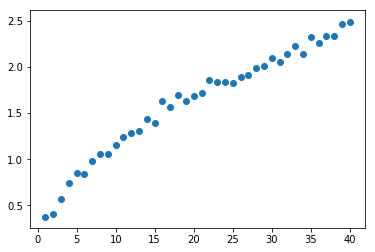

In [17]:
plot(mean_min_distances_same)

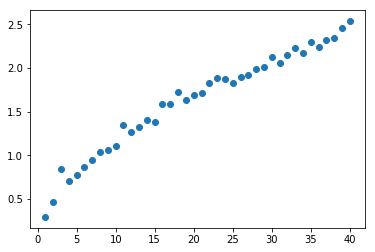

In [18]:
plot(mean_min_distances_opposite)

In [19]:
ratios = np.array(mean_min_distances_same) / np.array(mean_min_distances_opposite)

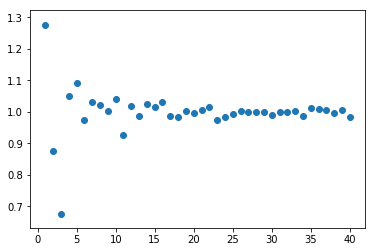

In [20]:
plot(ratios)

# Conclusion:

We can see on the graphs above that the average min distance to examples with the same / opposite class increases with dimension. That is also due to `curse of dimensionality`. Euclidean distance has such a property that everything is in a long distance if we are in high-dimensonial space. As we can see on the `ratios` plot the ratios are converging to one. This is due to the fact that there is little difference in the distances between different pairs of samples in high-dimensional space. 

In [21]:
!ipython nbconvert K-NN.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook K-NN.ipynb to html
[NbConvertApp] Writing 322109 bytes to K-NN.html
